# Notebook 2: Testing Various Models

In the original paper the train and validation sets were balanced with respect to the class labels however the testing data is very imbalanced. The dataset on the whole is very imbalanced with respect to the classes. We test the following models using mostly the default settings:

1. Logistic Regression
2. Ridge Regression
3. Linear Discriminant Analysis
4. Linear SVM Classifier
5. SGD Classifier
6. Naive Bayes Classifier
7. KNeighbors Classifier
8. Multilayer Perceptron

For models that don't have a predict_proba method we use a softmax to implement a similar functionality for the sake of ensembling over folds.

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 12

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import time
import os
import pyarrow
import gc

# Model evaluation
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Models
from sklearn.utils.extmath import softmax
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier


# Plotting
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Float precision
np.set_printoptions(precision = 3)

# Load Data

In [3]:
def get_data():
    try:
        #
        original = pd.read_feather('../data/original.feather')
    except:
        # Get Original Data
        original = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz', header = None)

        # Fix columns
        original.columns = ['Elevation', 'Aspect', 'Slope',
               'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
               'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
               'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
               'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
               'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
               'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
               'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
               'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
               'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
               'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
               'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
               'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
               'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
               'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40',
               'Cover_Type']

        for col, dtype in original.dtypes.iteritems():
            if dtype.name.startswith('int'):
                original[col] = pd.to_numeric(original[col], downcast ='integer')
            elif dtype.name.startswith('float'):
                original[col] = pd.to_numeric(original[col], downcast ='float')
        
        if not os.path.isdir('../data'):
            os.mkdir('../data')
        original.to_feather('../data/original.feather')
    return original

In [4]:
%%time
original = get_data()

# Get feature columns
features = [x for x in original.columns if x not in ['Id','Cover_Type']]
wilderness_cols = [x for x in features if x.startswith('Wild')]
soil_cols = [x for x in features if x.startswith('Soil')]
binary_cols = [x for x in features if x.startswith('Soil') or x in wilderness_cols]
numerical_cols = [x for x in features if x not in binary_cols]

# Encoder
old_encoder = LabelEncoder()
original["Cover_Type"] = old_encoder.fit_transform(original["Cover_Type"])

# Data structures for summary scores
metrics = list()

Wall time: 54 ms


# Scoring Functions

In [5]:
def train_original(sklearn_model, plot = True):
    
    # Original Training/Test Split
    X_temp = original[features].iloc[:15119]
    X_test = original[features].iloc[15119:]
    y_temp = original['Cover_Type'].iloc[:15119]
    y_test = original['Cover_Type'].iloc[15119:]
    labels = label_binarize(y_temp, classes = sorted(np.unique(y_temp)))

    
    # Store the out-of-fold predictions
    test_proba = np.zeros((X_test.shape[0],7))
    train_proba = np.zeros((X_temp.shape[0],7))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(X_temp,y_temp)):
       
        # Training and Validation Sets
        X_train = X_temp.iloc[train_idx]
        X_valid = X_temp.iloc[valid_idx]
        y_train = y_temp.iloc[train_idx]
        y_valid = y_temp.iloc[valid_idx]
        
        # Create model
        start = time.time()
        model = clone(sklearn_model)
        model.fit(X_train, y_train)

        try:
            # model supports predict_proba
            valid_proba = model.predict_proba(X_valid)
            test_proba += model.predict_proba(X_test)
        except:
            # model does not support predict proba
            valid_proba = softmax(model.decision_function(X_valid))
            test_proba += softmax(model.decision_function(X_test))
        
        # validation preds
        train_proba[valid_idx,:] = valid_proba
        valid_preds = np.argmax(valid_proba, axis = 1)
        
        # fold auc score
        fold_acc = accuracy_score(y_valid, valid_preds)
        end = time.time()
        print(f'Fold {fold}: {round(100 * fold_acc, 3)}% Accuracy in {round(end-start,2)}s.')
        scores[fold] = fold_acc
        times[fold] = end-start
        time.sleep(0.5)
    
    train_preds = np.argmax(train_proba, axis = 1)
    train_auc = roc_auc_score(labels, train_proba, multi_class = 'ovo')
    train_f1 = f1_score(y_temp, train_preds, average = 'macro')
    test_preds = np.argmax(test_proba, axis = 1)
    holdout = accuracy_score(y_test, test_preds)
    print("\nMean Acc (CV):", 100 * round(scores.mean(), 5))
    print("ROC AUC  (CV):", round(train_auc, 5))
    print("F1 Score (CV):", round(train_f1, 5))
    print('Submission   :', round(holdout, 5))
    print(f'Training Time: {round(times.sum(), 2)}s\n')
    
    if plot:
        # Plot confusion matrix
        fig, ax = plt.subplots(figsize = (8,6))
        cm = confusion_matrix(y_test, test_preds, normalize = 'true')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax = ax)
        plt.title("Confusion Matrix (% of Actual Labels)", fontsize=16)
        plt.xlabel("Predicted Labels", fontsize=14)
        plt.ylabel("Actual Labels", fontsize=14)
        plt.show()
    
    return scores.mean(), test_preds, holdout

# Logistic Regression

In [6]:
# Logistic Regression
logit_pipeline = make_pipeline(
    RobustScaler(),
    LogisticRegression(
        solver = 'newton-cg',
        n_jobs = -1,
        random_state = RANDOM_SEED,
    ),
)

Fold 0: 68.333% Accuracy in 4.76s.
Fold 1: 68.73% Accuracy in 2.21s.
Fold 2: 70.794% Accuracy in 2.66s.
Fold 3: 70.317% Accuracy in 2.9s.
Fold 4: 71.587% Accuracy in 3.44s.
Fold 5: 71.032% Accuracy in 3.06s.
Fold 6: 70.794% Accuracy in 2.37s.
Fold 7: 69.286% Accuracy in 2.41s.
Fold 8: 70.159% Accuracy in 2.26s.
Fold 9: 69.365% Accuracy in 2.16s.
Fold 10: 72.063% Accuracy in 2.1s.
Fold 11: 71.326% Accuracy in 2.12s.

Mean Acc (CV): 70.316
ROC AUC  (CV): 0.94993
F1 Score (CV): 0.70007
Submission   : 0.59373
Training Time: 32.45s



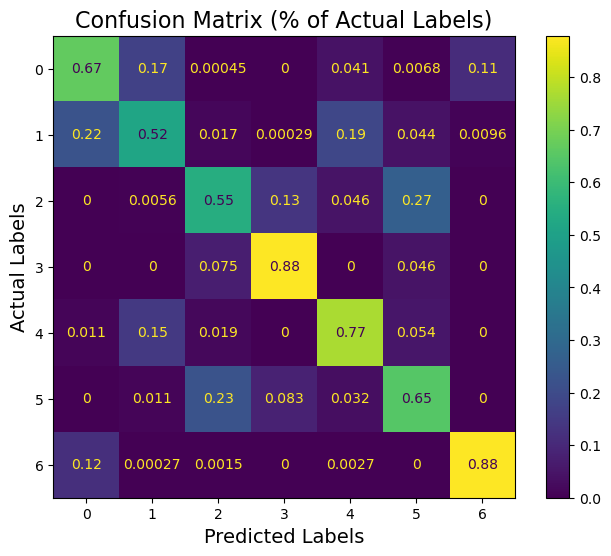

In [7]:
test_score, oof_preds, holdout = train_original(logit_pipeline)

metrics.append((
    'Logistic_Regression', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# Ridge Regression

In [8]:
# Ridge Regression
ridge_pipeline = make_pipeline(
    RobustScaler(),
    RidgeClassifierCV(),
)

Fold 0: 62.302% Accuracy in 0.47s.
Fold 1: 63.81% Accuracy in 0.51s.
Fold 2: 63.016% Accuracy in 0.46s.
Fold 3: 63.651% Accuracy in 0.47s.
Fold 4: 64.444% Accuracy in 0.45s.
Fold 5: 61.587% Accuracy in 0.45s.
Fold 6: 65.556% Accuracy in 0.51s.
Fold 7: 63.889% Accuracy in 0.5s.
Fold 8: 61.27% Accuracy in 0.45s.
Fold 9: 61.508% Accuracy in 0.42s.
Fold 10: 64.921% Accuracy in 0.44s.
Fold 11: 62.907% Accuracy in 0.47s.

Mean Acc (CV): 63.23800000000001
ROC AUC  (CV): 0.92186
F1 Score (CV): 0.62899
Submission   : 0.54269
Training Time: 5.6s



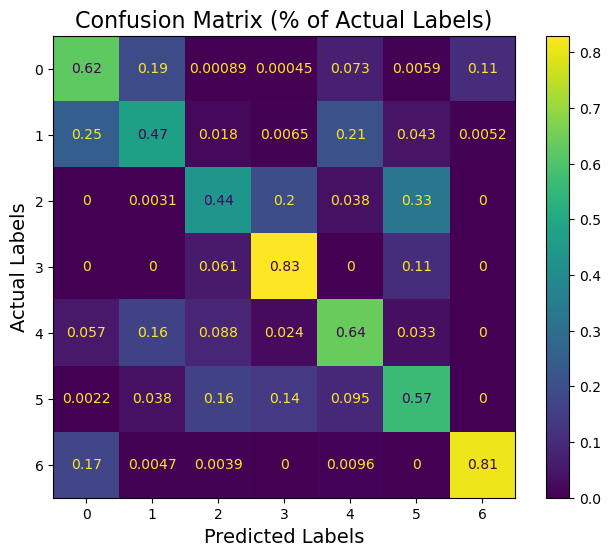

In [9]:
test_score, oof_preds, holdout  = train_original(ridge_pipeline)

metrics.append((
    'Ridge_Regression', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# Linear Discriminant Analysis

In [10]:
# Linear Discriminant Analysis
lda_pipeline = make_pipeline(
    RobustScaler(),
    LinearDiscriminantAnalysis(),
)

Fold 0: 62.937% Accuracy in 0.5s.
Fold 1: 65.159% Accuracy in 0.46s.
Fold 2: 64.841% Accuracy in 0.46s.
Fold 3: 64.127% Accuracy in 0.48s.
Fold 4: 66.349% Accuracy in 0.46s.
Fold 5: 63.73% Accuracy in 0.45s.
Fold 6: 66.667% Accuracy in 0.47s.
Fold 7: 65.556% Accuracy in 0.45s.
Fold 8: 62.063% Accuracy in 0.48s.
Fold 9: 62.857% Accuracy in 0.47s.
Fold 10: 66.825% Accuracy in 0.46s.
Fold 11: 65.449% Accuracy in 0.48s.

Mean Acc (CV): 64.713
ROC AUC  (CV): 0.93213
F1 Score (CV): 0.65027
Submission   : 0.58125
Training Time: 5.63s



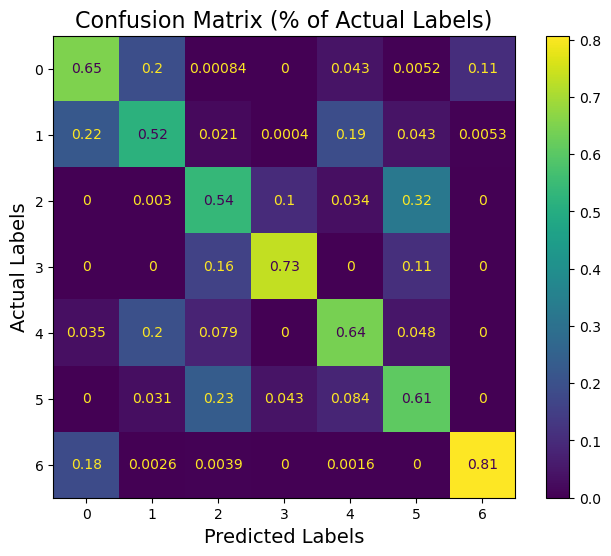

In [11]:
test_score, oof_preds, holdout = train_original(lda_pipeline)

metrics.append((
    'LDA', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# LinearSVC

In [12]:
# LinearSVC
svc_pipeline = make_pipeline(
    RobustScaler(), 
    LinearSVC(
        random_state = RANDOM_SEED
    )
)

Fold 0: 65.635% Accuracy in 2.21s.
Fold 1: 66.746% Accuracy in 2.23s.
Fold 2: 68.016% Accuracy in 2.21s.
Fold 3: 67.302% Accuracy in 2.27s.
Fold 4: 67.778% Accuracy in 2.33s.
Fold 5: 66.825% Accuracy in 2.37s.
Fold 6: 68.571% Accuracy in 2.25s.
Fold 7: 67.778% Accuracy in 2.16s.
Fold 8: 67.54% Accuracy in 2.22s.
Fold 9: 66.508% Accuracy in 2.17s.
Fold 10: 69.524% Accuracy in 2.19s.
Fold 11: 67.593% Accuracy in 2.19s.

Mean Acc (CV): 67.485
ROC AUC  (CV): 0.93523
F1 Score (CV): 0.6701
Submission   : 0.55081
Training Time: 26.81s



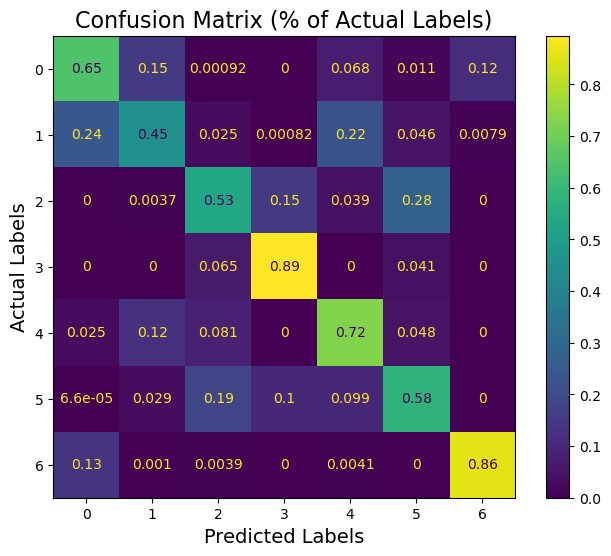

In [13]:
test_score, oof_preds, holdout = train_original(svc_pipeline)

metrics.append((
    'LinearSVC', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# Naive Bayes Classifier

In [14]:
# Naive Bayes Classifier
nb_pipeline = make_pipeline(
    RobustScaler(),
    MinMaxScaler(),
    GaussianNB(),
)

Fold 0: 46.27% Accuracy in 2.55s.
Fold 1: 46.349% Accuracy in 2.45s.
Fold 2: 47.778% Accuracy in 2.52s.
Fold 3: 48.81% Accuracy in 2.49s.
Fold 4: 46.984% Accuracy in 2.51s.
Fold 5: 48.175% Accuracy in 2.75s.
Fold 6: 47.937% Accuracy in 2.47s.
Fold 7: 47.778% Accuracy in 2.49s.
Fold 8: 46.667% Accuracy in 2.53s.
Fold 9: 47.937% Accuracy in 2.53s.
Fold 10: 47.937% Accuracy in 2.64s.
Fold 11: 46.545% Accuracy in 2.57s.

Mean Acc (CV): 47.43
ROC AUC  (CV): 0.88408
F1 Score (CV): 0.38327
Submission   : 0.13204
Training Time: 30.49s



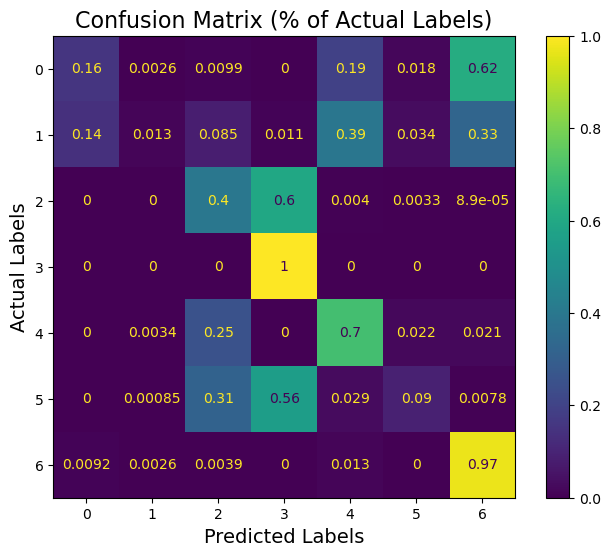

In [15]:
test_score, oof_preds, holdout = train_original(nb_pipeline)

metrics.append((
    'Naive_Bayes', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# Multilayer Perceptron

In [16]:
# Multi-layer Perceptron Classifier
mlp_pipeline = make_pipeline(
    RobustScaler(),
    MLPClassifier(
        hidden_layer_sizes=(len(features), len(features)//2),
        activation = 'tanh',
        early_stopping = True,
        validation_fraction = 0.2,
        n_iter_no_change = 5,
        random_state = RANDOM_SEED
    ),
)

Fold 0: 81.111% Accuracy in 5.69s.
Fold 1: 78.81% Accuracy in 4.92s.
Fold 2: 79.762% Accuracy in 4.78s.
Fold 3: 80.0% Accuracy in 6.87s.
Fold 4: 80.794% Accuracy in 5.29s.
Fold 5: 80.714% Accuracy in 7.71s.
Fold 6: 80.794% Accuracy in 6.88s.
Fold 7: 79.683% Accuracy in 6.78s.
Fold 8: 79.603% Accuracy in 6.78s.
Fold 9: 77.698% Accuracy in 4.33s.
Fold 10: 80.317% Accuracy in 6.65s.
Fold 11: 80.937% Accuracy in 6.25s.

Mean Acc (CV): 80.01899999999999
ROC AUC  (CV): 0.97275
F1 Score (CV): 0.79778
Submission   : 0.6834
Training Time: 72.94s



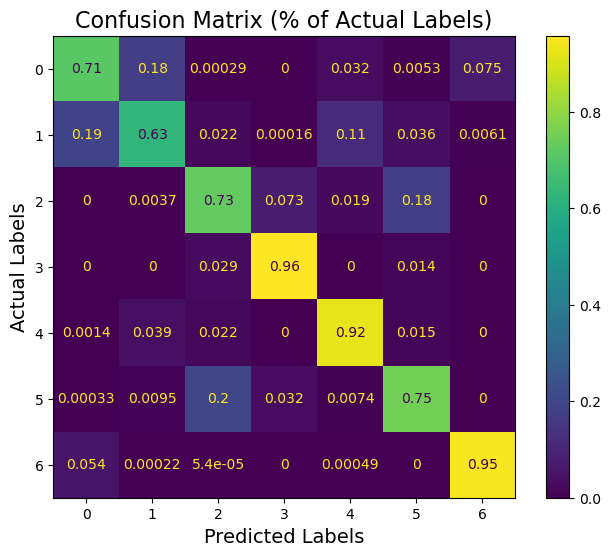

In [17]:
test_score, oof_preds, holdout = train_original(mlp_pipeline)

metrics.append((
    'Multilayer Perceptron', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# Summary

In [18]:
pd.DataFrame.from_records(
    data = metrics,
    columns = ['model','train','holdout','recall_0','recall_1','recall_2','recall_3','recall_4','recall_5','recall_6']
).sort_values('holdout', ascending = False)

,model,train,holdout,recall_0,recall_1,recall_2,recall_3,recall_4,recall_5,recall_6
5,Multilayer Perceptron,0.800186,0.683396,0.712758,0.628610,0.727489,0.957411,0.922406,0.751759,0.945613
0,Logistic_Regression,0.703156,0.593727,0.666973,0.517943,0.548236,0.879046,0.768035,0.648714,0.876785
2,LDA,0.647133,0.581255,0.649509,0.517491,0.538384,0.732538,0.640393,0.606957,0.806975
3,LinearSVC,0.674846,0.550813,0.649795,0.452485,0.531299,0.894378,0.724397,0.581443,0.856240
1,Ridge_Regression,0.632383,0.542686,0.624676,0.472745,0.436166,0.829642,0.635620,0.565726,0.806975
4,Naive_Bayes,0.474303,0.132036,0.156124,0.013388,0.395565,1.000000,0.701486,0.090156,0.971499


Our best result so far come from the `MLPClassifier`.